In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

In [2]:
model = 'AIT' # options LD or AIT
division = 'RDA'# options IDA or RDA

In [3]:
file_path_input_params_json = '../../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'SI/S20_division_coupling/'+model+'/'+division
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S20_division_coupling/AIT/RDA
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S20_division_coupling/AIT/RDA/parameter_set.csv


In [4]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)
colors = [blue, pinkish_red, green, dark_blue, yellow]

n_bins = 20
n_min_per_bin = 15

# Random error

In [5]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)

['/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S20_division_coupling/AIT/RDA/separate_division_AIT_RDA.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S20_division_coupling/AIT/RDA/separate_division_AIT_delta_RDA.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S20_division_coupling/AIT/RDA/AIT_RDA']


## Plot correlation added initiation volume with initiation volume

In [6]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

def return_array_of_initiation_and_birth_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init'], data_frame['v_b_before_init']

def return_array_of_birth_and_division_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_div_events')
    return data_frame['v_b'], data_frame['v_d']

In [7]:
import scipy.stats

def return_sem(np_array):
#     print('np_array', np_array)
    if np_array.size == 0:
#         print('size of np array in return_sem was zero')
        return np.nan
    else:
        df = pd.DataFrame(data=np_array)
#         print('df', df)
#         print('sem', df.sem())
        return df.sem()

def given_dataframe_return_bins_with_mean_sem(data_frame, data_x, data_y, n_bins, n_min_per_bin):
    x_max = data_frame[data_x].max()
    x_min = data_frame[data_x].min()
    bin_np, bin_pos = np.histogram(data_frame[data_x], bins=np.linspace(x_min, x_max, n_bins))
    minpos = bin_pos[np.where(bin_np>n_min_per_bin)[0][0]]
    maxpos = bin_pos[np.where(bin_np>n_min_per_bin)[0][-1]]
    return fig_data[(fig_data.data_x>minpos)&(fig_data.data_x<maxpos)]

def return_label_relaxation_rate(relaxation_rate, correlation):
    return r'$\theta$= {}, R= {} '.format(np.round(relaxation_rate, 3),
                                        np.round(correlation, 3))

def return_label_doubling_time(doubling_time, correlation):
    return r'$\tau_{{\rm d}}$= {}, R= {} '.format(np.round(doubling_time, 3),
                                        np.round(correlation, 3))

def return_label_number_samples(number, correlation):
    return r'N= {}, R= {} '.format(np.round(number, 3),
                                        np.round(correlation, 3))

mean: 0.26304972452676284 std: 0.016911992245491617 CV: 0.06429199755261854
Leght of data frame: 995
[  7.  60. 152. 232. 240. 180.  90.  23.  10.   1.]


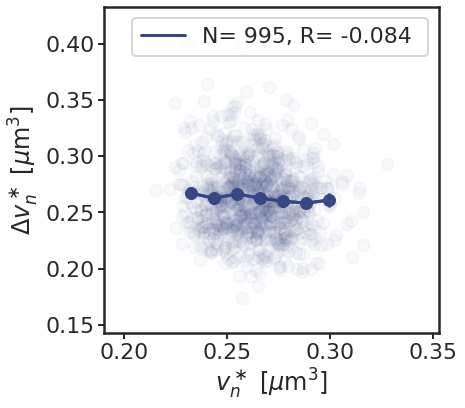

In [8]:
sns.set(style="white")
sns.set_context("poster")
sns.set_style("ticks")
df_correlations = []
data_frame = data_frame.sort_values(by=['relaxation_rate'])

for index, row in data_frame.iterrows():
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    v_init_np = v_init_np[3:]
    print('mean:', np.mean(v_init_np), 'std:', np.std(v_init_np), 'CV:', np.std(v_init_np)/np.mean(v_init_np))
    df_item = pd.DataFrame({"v_init" : v_init_np[:-1],
                            "delta_v_init" : 2*v_init_np[1:]-v_init_np[:-1],
                            "relaxation_rate": row.relaxation_rate,
                            "doubling_time": 1/row.doubling_rate
                                   })
    df_item['correlation'] = df_item['v_init'].corr(df_item['delta_v_init'], method='pearson')
    df_item["color"] = df_item.apply(lambda row: colors[index], axis=1)
    df_item["mean"] = df_item.apply(lambda row: np.mean(v_init_np), axis=1)
    print('Leght of data frame:', len(df_item.index))
    df_correlations.append(df_item)
    
fig, ax = plt.subplots(figsize=(6,6))
for df in df_correlations:
    # plot raw datter as scatter plot
    ax.scatter(df['v_init'], 
               df['delta_v_init'], 
               alpha=0.03, 
               color=df['color'][0])
    # bin data and plot mean and sem per bin
    bin_count, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                         df['delta_v_init'], 
                                                         'count', 
                                                         bins=10)
    print(bin_count)
    bin_means, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                             df['delta_v_init'], 
                                                             'mean', 
                                                             bins=10)
    
#     print('mean', bin_means)
    bin_sem, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                             df['delta_v_init'], 
                                                             return_sem, 
                                                             bins=10)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_means_cut = bin_means[bin_count >=n_min_per_bin]
    bin_centers_cut = bin_centers[bin_count >=n_min_per_bin]
    bin_sem_cut = bin_sem[bin_count >=n_min_per_bin]

    ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_number_samples(len(df.index),
                                                                          df['correlation'][0]))
    
#     ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_doubling_time(df['doubling_time'][0],
#                                                                           df['correlation'][0]))
    ax.errorbar(bin_centers_cut, bin_means_cut, yerr=bin_sem_cut, marker='o', c=df['color'][0])
#     ax.axhline(df["mean"][0], linestyle='--', linewidth=3, color=blue)
    ax.plot()
    
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
# ax.set_yticks([0.1, 0.2,  0.3])
# ax.set_yticklabels([ r'0.1', r'0.2', r'0.3'])    
# ax.set(ylim=(0.05,0.35))
# ax.set(xlim=(0.05,0.35))
ax.legend(loc='upper right')
ax.set(xlabel=r'$v^\ast_n$ [$\mu$m$^3$]', ylabel=r'$\Delta v^\ast_n$ [$\mu$m$^3$]')
plt.savefig(file_path + '/separate_division_'+model+'_'+division+'.pdf', format='pdf', bbox_inches='tight')
    

## Correlation initiation volume with birth volume

In [9]:
def return_array_of_initiation_and_birth_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init'], data_frame['v_b_before_init']

[  1.   1.  10.  42. 113. 155.  92.  61.  17.   3.]


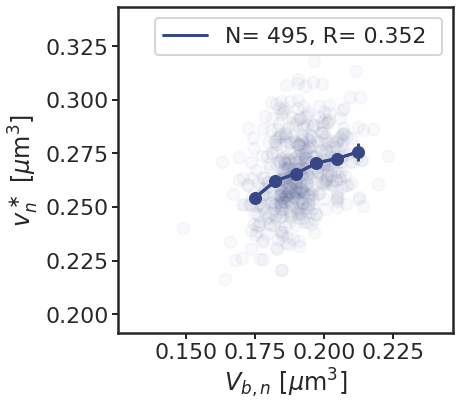

In [11]:
sns.set(style="white")
sns.set_context("poster")
sns.set_style("ticks")
df_correlations = []
data_frame = data_frame.sort_values(by=['relaxation_rate'])

for index, row in data_frame.iterrows():    
    v_init_per_ori, t_init, v_b_before_init = return_array_of_initiation_and_birth_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    v_b_before_init_np = v_b_before_init.to_numpy()
    v_b_before_init_np = v_b_before_init_np[3:]
    v_init_np = v_init_np[3:]
    df_item = pd.DataFrame({"v_init" :  v_init_np[1:],
                            "v_b_before_init" : v_b_before_init_np[1:],
                            "relaxation_rate": row.relaxation_rate,
                            "doubling_time": 1/row.doubling_rate
                                   })
    df_item['correlation'] = df_item['v_b_before_init'].corr(df_item['v_init'], method='pearson')
    df_item["color"] = df_item.apply(lambda row: colors[index], axis=1)
    df_correlations.append(df_item)
    
fig, ax = plt.subplots(figsize=(6,6))
for df in df_correlations:
    # plot raw datter as scatter plot
    ax.scatter(df['v_b_before_init'], 
               df['v_init'], 
               alpha=0.03, 
               color=df['color'][0])
    # bin data and plot mean and sem per bin
    bin_count, bin_edges, binnumber = stats.binned_statistic(df['v_b_before_init'], 
                                                     df['v_init'], 
                                                     'count', 
                                                     bins=10)
    print(bin_count)
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(df['v_b_before_init'], 
                                                             df['v_init'], 
                                                             'mean', 
                                                             bins=10)
    
    bin_sem, bin_edges, binnumber = stats.binned_statistic(df['v_b_before_init'], 
                                                             df['v_init'], 
                                                             return_sem, 
                                                             bins=10)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    # take out bins with less than 15 samples
    bin_means_cut = bin_means[bin_count >=n_min_per_bin]
    bin_centers_cut = bin_centers[bin_count >=n_min_per_bin]
    bin_sem_cut = bin_sem[bin_count >=n_min_per_bin]
    
    ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_number_samples(len(df.index),
                                                                          df['correlation'][0]))
#     ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_doubling_time(df['doubling_time'][0],
#                                                                       df['correlation'][0]))
    ax.errorbar(bin_centers_cut, bin_means_cut, yerr=bin_sem_cut, marker='o', c=df['color'][0])
    ax.plot()
    
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
# ax.set_yticks([0.25, 0.3, 0.35])
# ax.set_yticklabels([  r'0.25', r'0.3', r'0.35'])   
# ax.set_yticks([0.1, 0.2,  0.3])
# ax.set_yticklabels([ r'0.1', r'0.2', r'0.3'])    
# ax.set(ylim=(0.05,0.35))
# ax.set(xlim=(0.05,0.35))
ax.legend(loc='upper right')
ax.set(xlabel=r'$V_{b, n}$ [$\mu$m$^3$]', ylabel=r'$v^\ast_n$ [$\mu$m$^3$]')
plt.savefig(file_path + '/separate_division_'+model+'_vb.pdf', format='pdf', bbox_inches='tight')
    

# Added volume from initiation to division

In [12]:
sns.set(style="white")
sns.set_context("poster")
sns.set_style("ticks")
df_correlations = []
data_frame = data_frame.sort_values(by=['relaxation_rate'])

for index, row in data_frame.iterrows():    
    v_init_per_ori, t_init, v_b_before_init = return_array_of_initiation_and_birth_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    v_b_before_init_np = v_b_before_init.to_numpy()
    v_b_before_init_np = v_b_before_init_np
    v_init_np = v_init_np
    
    v_b, v_d = return_array_of_birth_and_division_volumes(row.path_dataset)
    v_b_np = v_b.to_numpy()
    v_d_np = v_d.to_numpy()
#     print(v_b_np, v_b_before_init_np)
    print(v_b_np.size, v_b_before_init_np.size)
    v_init_to_v_d = v_d_np - v_init_np[1:-1]
    df_item = pd.DataFrame({"v_init" :  v_init_np[1:-1],
                            "v_init_to_v_d" : v_init_to_v_d,
                            "relaxation_rate": row.relaxation_rate,
                            "doubling_time": 1/row.doubling_rate
                                   })
    df_item['correlation'] = df_item['v_init'].corr(df_item['v_init_to_v_d'], method='pearson')
    df_item["color"] = df_item.apply(lambda row: colors[index], axis=1)
    df_correlations.append(df_item)
    
fig, ax = plt.subplots(figsize=(6,6))
for df in df_correlations:
    # plot raw datter as scatter plot
    ax.scatter(df['v_init'], 
               df['v_init_to_v_d'], 
               alpha=0.03, 
               color=df['color'][0])
    # bin data and plot mean and sem per bin
    bin_count, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                     df['v_init_to_v_d'], 
                                                     'count', 
                                                     bins=10)
    print(bin_count)
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                             df['v_init_to_v_d'], 
                                                             'mean', 
                                                             bins=10)
    
    bin_sem, bin_edges, binnumber = stats.binned_statistic(df['v_init'], 
                                                             df['v_init_to_v_d'], 
                                                             return_sem, 
                                                             bins=10)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    # take out bins with less than 15 samples
    bin_means_cut = bin_means[bin_count >=n_min_per_bin]
    bin_centers_cut = bin_centers[bin_count >=n_min_per_bin]
    bin_sem_cut = bin_sem[bin_count >=n_min_per_bin]
    
    ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_number_samples(len(df.index),
                                                                          df['correlation'][0]))
#     ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_doubling_time(df['doubling_time'][0],
#                                                                       df['correlation'][0]))
    ax.errorbar(bin_centers_cut, bin_means_cut, yerr=bin_sem_cut, marker='o', c=df['color'][0])
    ax.plot()
    
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
# ax.set_yticks([0.25, 0.3, 0.35])
# ax.set_yticklabels([  r'0.25', r'0.3', r'0.35'])   
# ax.set_yticks([0.1, 0.2,  0.3])
# ax.set_yticklabels([ r'0.1', r'0.2', r'0.3'])    
# ax.set(ylim=(0.05,0.35))
# ax.set(xlim=(0.05,0.35))
ax.legend(loc='upper right')
ax.set(xlabel=r'$v^\ast_n$ [$\mu$m$^3$]', ylabel=r'$\Delta v^\ast_{id, n}$ [$\mu$m$^3$]')
plt.savefig(file_path + '/separate_division_'+model+'_v_init_to_vd.pdf', format='pdf', bbox_inches='tight')
    

498 499


ValueError: operands could not be broadcast together with shapes (498,) (497,) 

# Added volume from birth to division

[  2.  18.  87. 193. 299. 238. 120.  24.  13.   2.]


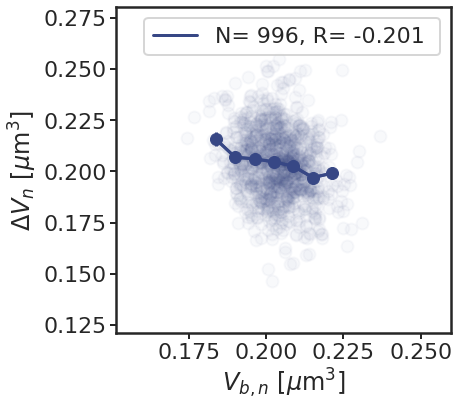

In [66]:
sns.set(style="white")
sns.set_context("poster")
sns.set_style("ticks")
df_correlations = []
data_frame = data_frame.sort_values(by=['relaxation_rate'])

for index, row in data_frame.iterrows():    
    v_b, v_d = return_array_of_birth_and_division_volumes(row.path_dataset)
    v_b_np = v_b.to_numpy()
    v_d_np = v_d.to_numpy()
    df_item = pd.DataFrame({"v_b" :  v_b_np[1:],
                            "v_d" : v_d_np[1:],
                            "added" : v_d_np[1:] - v_b_np[1:],
                            "relaxation_rate": row.relaxation_rate,
                            "doubling_time": 1/row.doubling_rate
                                   })
    df_item['correlation'] = df_item['v_b'].corr(df_item['added'], method='pearson')
    df_item["color"] = df_item.apply(lambda row: colors[index], axis=1)
    df_correlations.append(df_item)
    
fig, ax = plt.subplots(figsize=(6,6))
for df in df_correlations:
    # plot raw datter as scatter plot
    ax.scatter(df['v_b'], 
               df['added'], 
               alpha=0.03, 
               color=df['color'][0])
    # bin data and plot mean and sem per bin
    bin_count, bin_edges, binnumber = stats.binned_statistic(df['v_b'], 
                                                     df['added'], 
                                                     'count', 
                                                     bins=10)
    print(bin_count)
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(df['v_b'], 
                                                             df['added'], 
                                                             'mean', 
                                                             bins=10)
    
    bin_sem, bin_edges, binnumber = stats.binned_statistic(df['v_b'], 
                                                             df['added'], 
                                                             return_sem, 
                                                             bins=10)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    # take out bins with less than 15 samples
    bin_means_cut = bin_means[bin_count >=n_min_per_bin]
    bin_centers_cut = bin_centers[bin_count >=n_min_per_bin]
    bin_sem_cut = bin_sem[bin_count >=n_min_per_bin]
    
    ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_number_samples(len(df.index),
                                                                          df['correlation'][0]))
#     ax.plot(bin_centers_cut, bin_means_cut, c=df['color'][0], label=return_label_doubling_time(df['doubling_time'][0],
#                                                                       df['correlation'][0]))
    ax.errorbar(bin_centers_cut, bin_means_cut, yerr=bin_sem_cut, marker='o', c=df['color'][0])
    ax.plot()
    
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
# ax.set_yticks([0.25, 0.3, 0.35])
# ax.set_yticklabels([  r'0.25', r'0.3', r'0.35'])   
# ax.set_yticks([0.1, 0.2,  0.3])
# ax.set_yticklabels([ r'0.1', r'0.2', r'0.3'])    
# ax.set(ylim=(0.05,0.35))
# ax.set(xlim=(0.05,0.35))
ax.legend(loc='upper right')
ax.set(xlabel=r'$V_{b, n}$ [$\mu$m$^3$]', ylabel=r'$\Delta V_n$ [$\mu$m$^3$]')
plt.savefig(file_path + '/separate_division_'+model+'_'+fluct+'_vb_to_vd.pdf', format='pdf', bbox_inches='tight')
    